In [ ]:
import numpy as np
import torch
import skimage
from skimage.data import astronaut
import matplotlib.pyplot as plt
import cv2
from numpy.linalg import svd
%load_ext autoreload
%autoreload 2


from harris_loss import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import os

os.listdir(".")

['baseline.ipynb', 'harris_loss.py', '__pycache__']

In [ ]:
img = astronaut()

In [ ]:
# Sobel x-axis kernel
SOBEL_X = np.array((
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]), dtype="int32")

# Sobel y-axis kernel
SOBEL_Y = np.array((
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]), dtype="int32")

# Gaussian kernel
GAUSS = np.array((
    [1/16, 2/16, 1/16],
    [2/16, 4/16, 2/16],
    [1/16, 2/16, 1/16]), dtype="float64")

In [ ]:
def convolve(img, kernel):
    """
    Convolve function for odd dimensions.
    IT CONVOLVES IMAGES
    """
    if kernel.shape[0] % 2 != 1 or kernel.shape[1] % 2 != 1:
        raise ValueError("Only odd dimensions on filter supported")

    img_height = img.shape[0]
    img_width = img.shape[1]
    pad_height = kernel.shape[0] // 2
    pad_width = kernel.shape[1] // 2
    
    pad = ((pad_height, pad_height), (pad_height, pad_width))
    g = np.empty(img.shape, dtype=np.float64)
    img = np.pad(img, pad, mode='constant', constant_values=0)
    # Do convolution
    for i in np.arange(pad_height, img_height+pad_height):
        for j in np.arange(pad_width, img_width+pad_width):
            roi = img[i - pad_height:i + pad_height +
                      1, j - pad_width:j + pad_width + 1]
            g[i - pad_height, j - pad_width] = (roi*kernel).sum()

    if (g.dtype == np.float64):
        kernel = kernel / 255.0
        kernel = (kernel*255).astype(np.uint8)
    else:
        g = g + abs(np.amin(g))
        g = g / np.amax(g)
        g = (g*255.0)
    return g

In [ ]:
gray_image = skimage.color.rgb2gray(img)

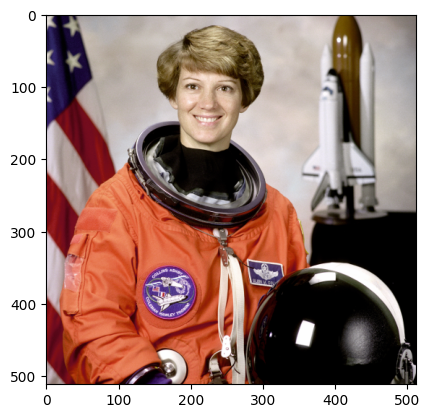

In [ ]:
plt.imshow(img)

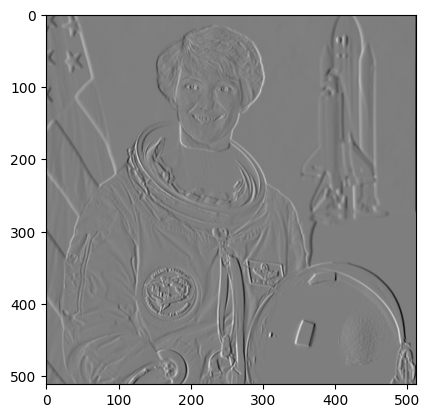

In [ ]:
plt.imshow(convolve(gray_image, SOBEL_X), cmap='gray')

In [ ]:
def blur_image(image, sigma_color=10, sigma_space=10, radius: float=None):    
    # Apply bilateral filter
    blurred_image = cv2.bilateralFilter(image, d=-1, sigmaColor=sigma_color, sigmaSpace=sigma_space)
    if radius:
        blurred_image = cv2.GaussianBlur(blurred_image, (radius, radius), 0)
    return blurred_image

In [ ]:
from skimage.color import rgb2gray
gray_image = rgb2gray(img)

In [ ]:
dx = convolve(gray_image, SOBEL_X)
dy = convolve(gray_image, SOBEL_Y)

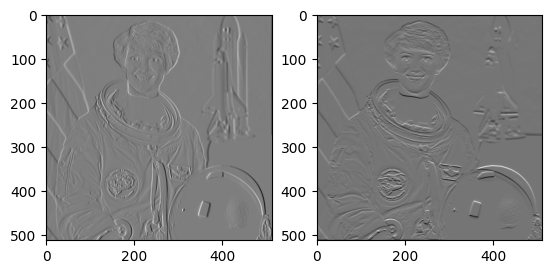

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(dx, cmap='gray')
axes[1].imshow(dy, cmap='gray')
plt.show()

In [ ]:
dx_gauss = convolve(dx, GAUSS)
dy_gauss = convolve(dy, GAUSS)

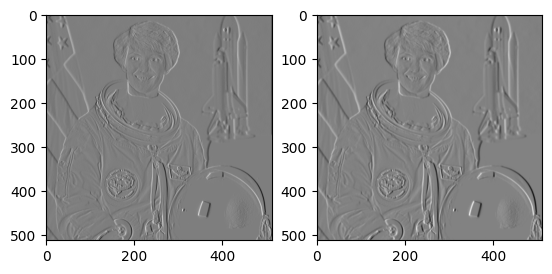

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(dx, cmap='gray')
axes[1].imshow(dx_gauss, cmap='gray')
plt.show()

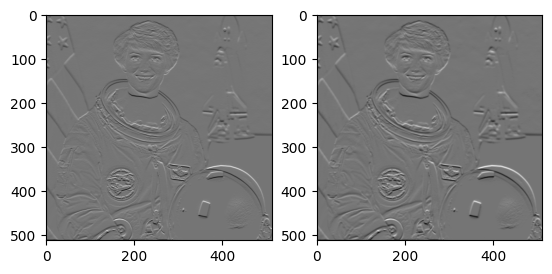

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(dy, cmap='gray')
axes[1].imshow(dy_gauss, cmap='gray')
plt.show()

In [ ]:
from typing import Union

In [89]:
# from sklearn.
def apply_sobel_kernels(gray, gauss: bool):
    dx = convolve(gray, SOBEL_X)
    dy = convolve(gray, SOBEL_Y)
    dx2 = np.square(dx)
    dy2 = np.square(dy)
    dxdy = dx * dy
    if gauss:
        dx2 = convolve(dx2, GAUSS)
        dy2 = convolve(dy2, GAUSS)
        dxdy = convolve(dxdy, GAUSS)
    return dx2, dy2, dxdy


def plot_gradients(d1, d2, title):
    fig, axes = plt.subplots(ncols=2, figsize=(15,10))
    fig.suptitle(title)
    axes[0].imshow(d1, cmap="gray")
    axes[1].imshow(d2, cmap='gray')
    plt.show()


def plot_difference(gray1, gray2, dx1, dx2, dy1, dy2):
    fig, axes = plt.subplots(ncols=3, figsize=(15, 10))
    axes[0].imshow(gray1, cmap='gray')
    axes[1].imshow(gray2, cmap='gray')
    axes[2].imshow(np.abs(gray1 - gray2), cmap='jet')
    axes[0].set_title('Original gray')
    axes[1].set_title('Blurred gray')
    axes[2].set_title("Difference in gray")
    plt.show()

    fig, axes = plt.subplots(ncols=3, figsize=(15, 10))
    axes[0].imshow(dx1, cmap='gray')
    axes[1].imshow(dx2, cmap='gray')
    axes[2].imshow(np.abs(dx1 - dx2), cmap='jet')
    axes[0].set_title('Original derivative x')
    axes[1].set_title('Blurred derivative x')
    axes[2].set_title("Difference in derivatives x")
    plt.show()


    
    fig, axes = plt.subplots(ncols=3, figsize=(15, 10))
    axes[0].imshow(dy1, cmap='gray')
    axes[1].imshow(dy2, cmap='gray')
    axes[2].imshow(np.abs(dy1 - dy2), cmap='jet')
    axes[0].set_title('Original derivative y')
    axes[1].set_title('Blurred derivative y')
    axes[2].set_title("Difference in derivatives y")
    plt.show()


def plot_eigenvectors(u1, u2, vt1, vt2, sigma_x1, sigma_x2):
    fig, axes = plt.subplots(ncols=3, figsize=(15, 10))
    axes[0].imshow(u1, cmap='gray')
    axes[1].imshow(u2, cmap='gray')
    axes[2].imshow(np.abs(u1 - u2), cmap='jet')
    axes[0].set_title('Original U')
    axes[1].set_title('Blurred U')
    axes[2].set_title(f"Difference in U. Max lambda: {np.max(sigma_x1), np.max(sigma_x2)}")
    plt.show()

    fig, axes = plt.subplots(ncols=3, figsize=(15, 10))
    axes[0].imshow(vt1, cmap='gray')
    axes[1].imshow(vt2, cmap='gray')
    axes[2].imshow(np.abs(vt1 - vt2), cmap='jet')
    axes[0].set_title('Original V*')
    axes[1].set_title('Blurred V*')
    axes[2].set_title(f"Difference in V*. Min lambda: {np.min(sigma_x1), np.min(sigma_x2)}")
    plt.show()


def harris_loss(rgb1, rgb2, alpha: float=0.1, gauss: bool=True, p: Union[int, str]=1):
    """
    If $\alpha = 0$ then it is the p-distance of ellipsis areas.
    """
    gray1 = rgb2gray(rgb1)
    gray2 = rgb2gray(rgb2)
    dx2_1, dy2_1, dxdy_1 = apply_sobel_kernels(gray1, gauss)
    dx2_2, dy2_2, dxdy_2 = apply_sobel_kernels(gray2, gauss)
    
    harris_response1 = dx2_1*dy2_1 - np.square(dxdy_1) - alpha*np.square(dx2_1 + dy2_1)
    harris_response2 = dx2_2*dy2_2 - np.square(dxdy_2) - alpha*np.square(dx2_2 + dy2_2)
    plot_gradients(harris_response1, harris_response2, "Harris response maps")
    return calculate_p_loss(harris_response1, harris_response2, p=1)
    # u1, sigma_x1, vt1 = svd(dx1)
    # u2, sigma_x2, vt2 = svd(dx2)
    # harris_response1 = np.abs(np.max(sigma_x1) * np.min(sigma_x1) - alpha * (np.max(sigma_x1) + np.min(sigma_x1)))
    # harris_response2 = np.abs(np.max(sigma_x2) * np.min(sigma_x2) - alpha * (np.max(sigma_x2) + np.min(sigma_x2)))

    # x_loss = calculate_p_loss(harris_response1, harris_response2, p=p)
    # plot_gradients(dx1, dx2, title=x_loss)
    # plot_eigenvectors(u1, u2, vt1, vt2, sigma_x1, sigma_x2)

    # u1, sigma_y1, vt1 = svd(dy1)
    # u2, sigma_y2, vt2 = svd(dy2)
    # harris_response1 = np.abs(np.max(sigma_y1) * np.min(sigma_y1) - alpha * (np.max(sigma_y1) + np.min(sigma_y1)))
    # harris_response2 = np.abs(np.max(sigma_y2) * np.min(sigma_y2) - alpha * (np.max(sigma_y2) + np.min(sigma_y2)))

    # y_loss = calculate_p_loss(harris_response1, harris_response2, p=p)
    # plot_gradients(dx1, dx2, title=y_loss)
    # plot_eigenvectors(u1, u2, vt1, vt2, sigma_x1, sigma_x2)
    

    # plot_difference(gray1, gray2, dx1, dx2, dy1, dy2)

    # return x_loss + y_loss

def calculate_p_loss(x1, x2, p):
    if p == 1:
        return np.abs(x1 - x2).mean()

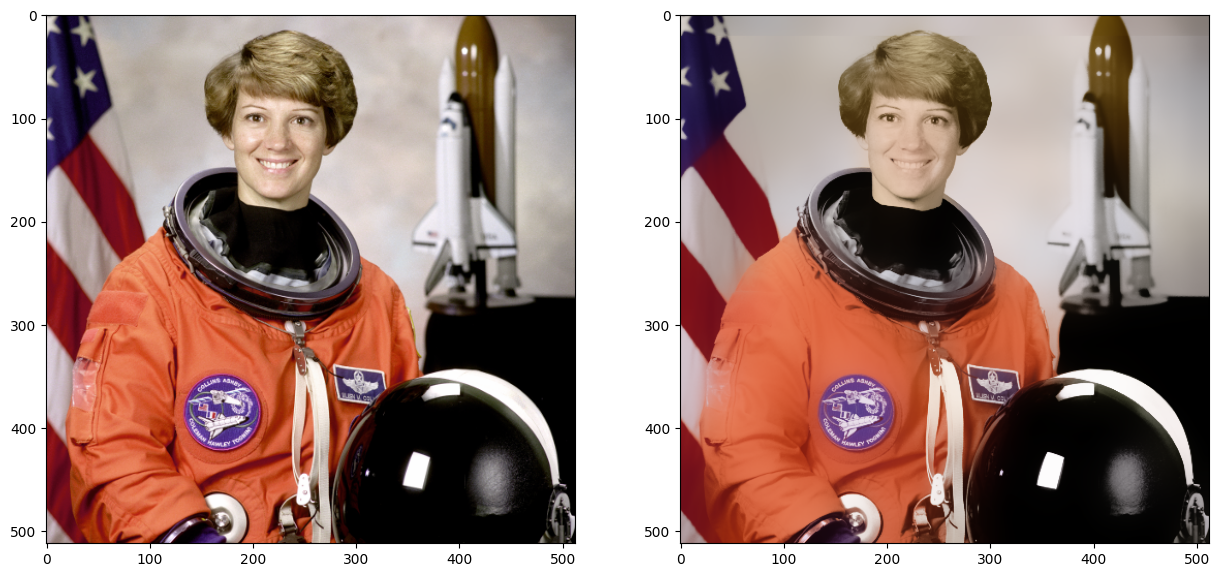

In [79]:
blurred_img = blur_image(img, sigma_color=100, sigma_space=20)
fig, axes = plt.subplots(ncols=2, figsize=(15, 10))

axes[0].imshow(img)
axes[1].imshow(blurred_img)


In [90]:
def calculate_total_variation_difference(image1, image2):
    # Convert the images to grayscale
    if len(image1.shape) > 2:
        image1 = np.mean(image1, axis=2)
    if len(image2.shape) > 2:
        image2 = np.mean(image2, axis=2)

    # Define the horizontal and vertical gradient filters
    gradient_x = np.array([[0, 0, 0], [-1, 1, 0], [0, 0, 0]])
    gradient_y = np.array([[0, -1, 0], [0, 1, 0], [0, 0, 0]])

    # Compute the gradient for each image
    gradient1_x = convolve(image1, gradient_x)
    gradient1_y = convolve(image1, gradient_y)
    gradient2_x = convolve(image2, gradient_x)
    gradient2_y = convolve(image2, gradient_y)

    # Calculate the total variation of each image
    total_variation1 = np.mean(np.sqrt(gradient1_x**2 + gradient1_y**2))
    total_variation2 = np.mean(np.sqrt(gradient2_x**2 + gradient2_y**2))

    # Calculate the difference of the total variations
    total_variation_diff = np.abs(total_variation1 - total_variation2)

    return total_variation_diff

Blurred image is obtained:   0%|          | 0/7 [00:00<?, ?it/s]

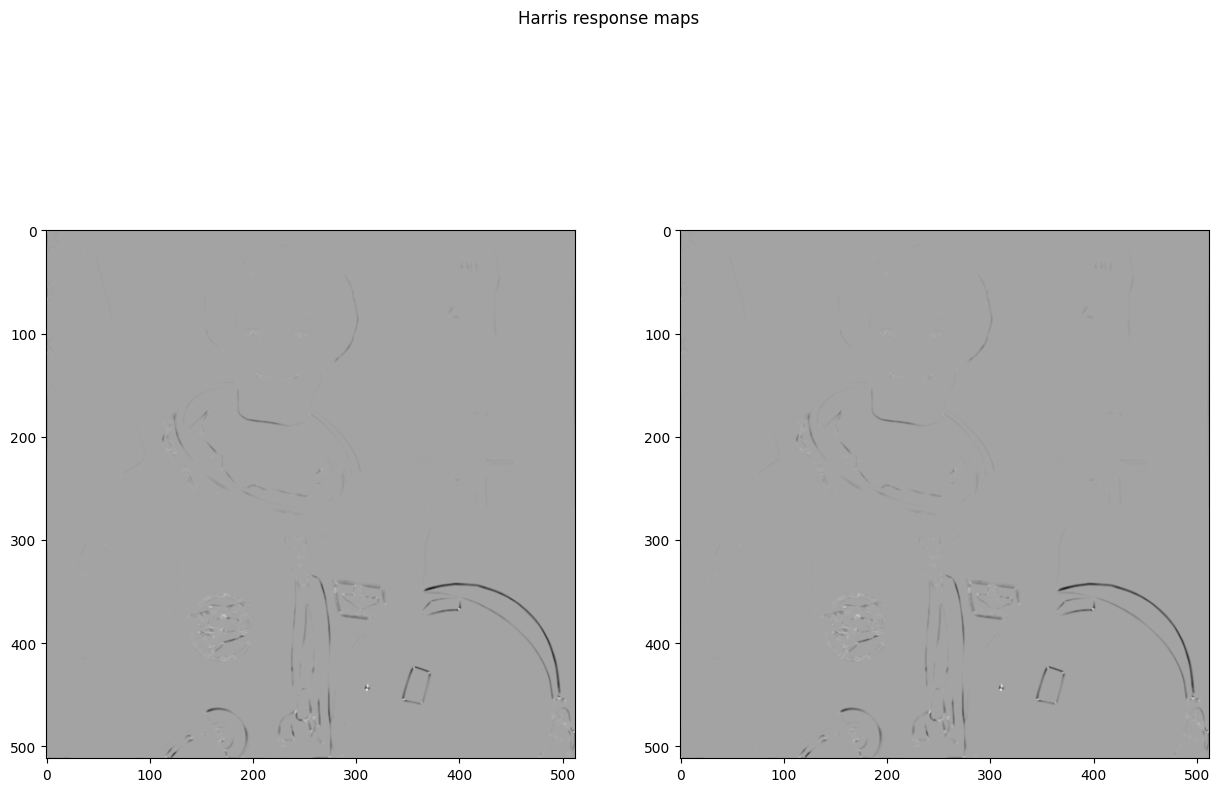

Blurred image is obtained:  14%|█▍        | 1/7 [00:20<02:05, 20.90s/it]         

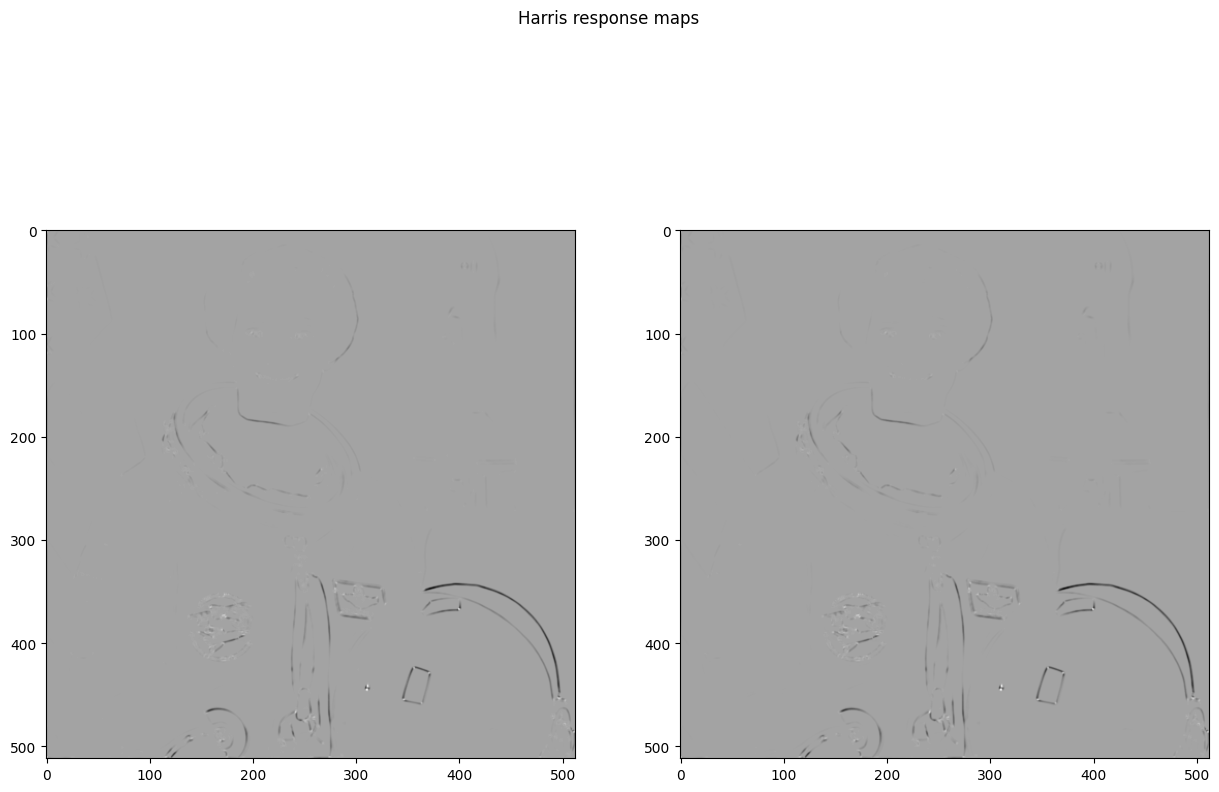

Blurred image is obtained:  29%|██▊       | 2/7 [00:41<01:37, 19.49s/it]         

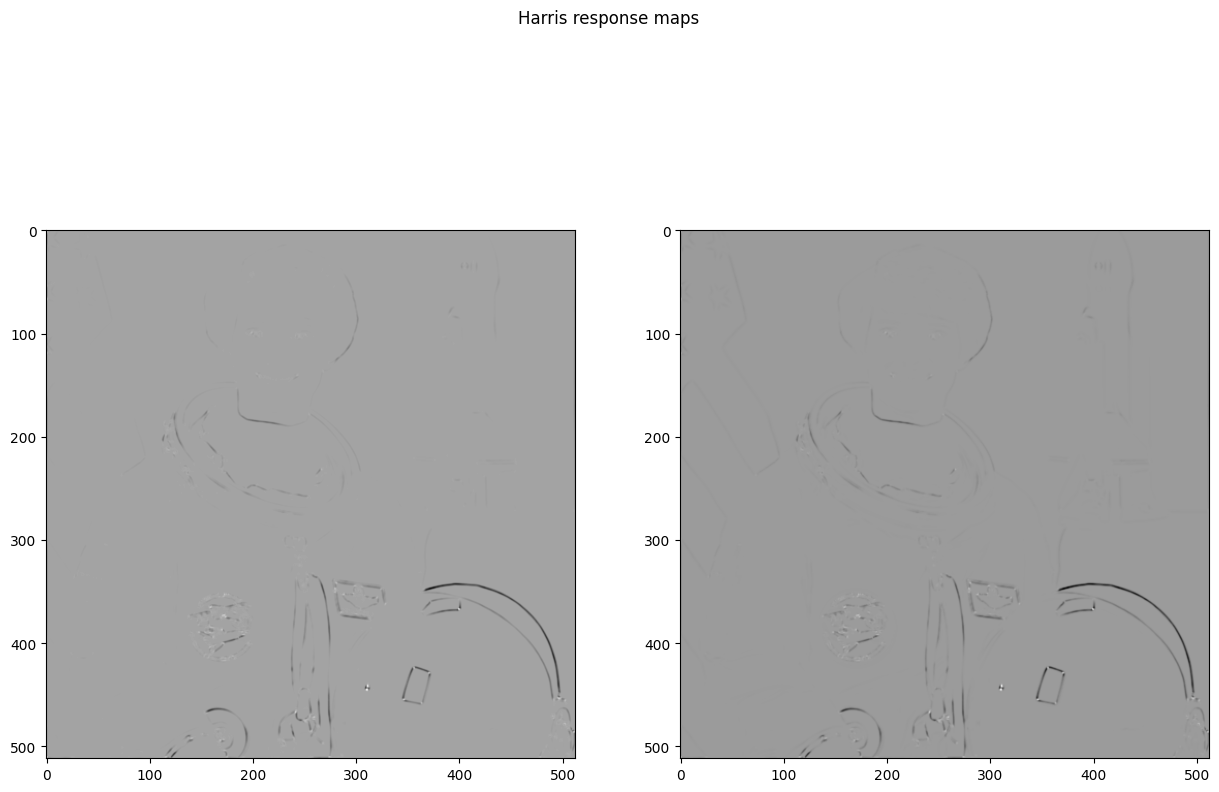

Blurred image is obtained:  43%|████▎     | 3/7 [01:06<01:20, 20.18s/it]         

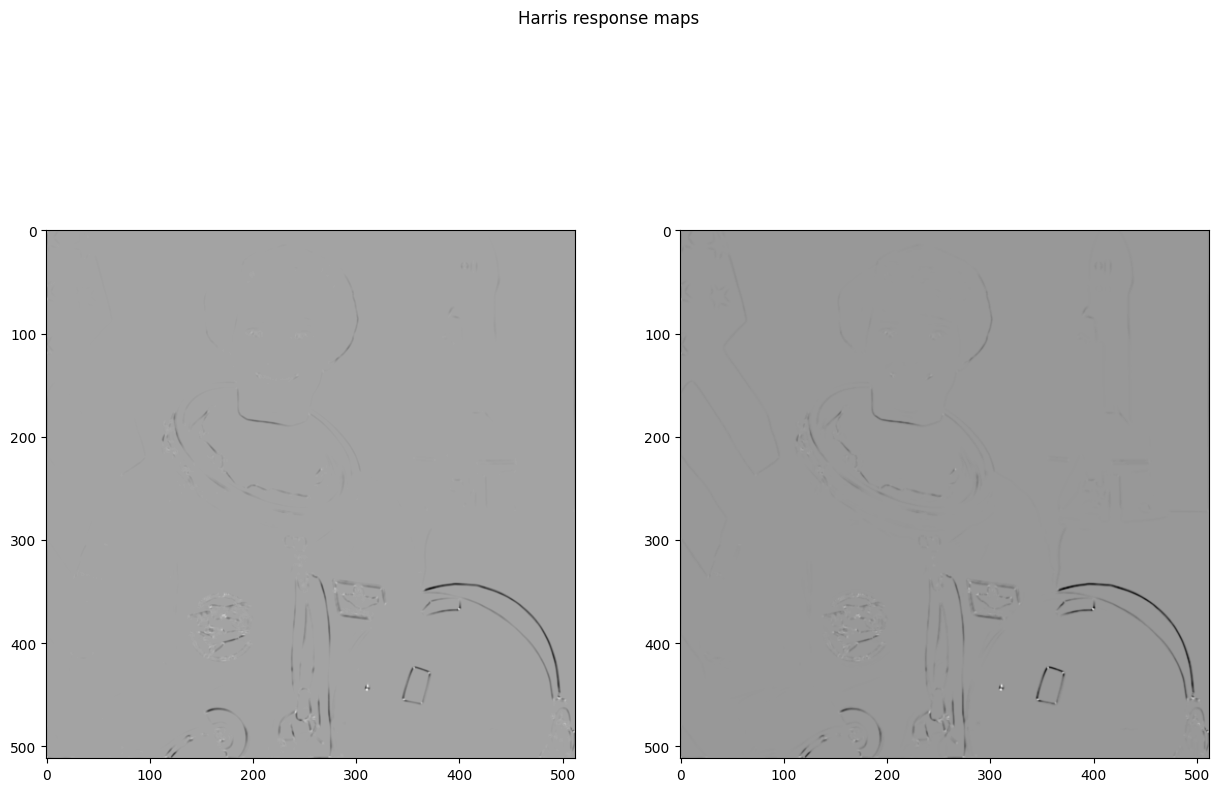

Blurred image is obtained:  57%|█████▋    | 4/7 [01:39<01:05, 21.85s/it]         

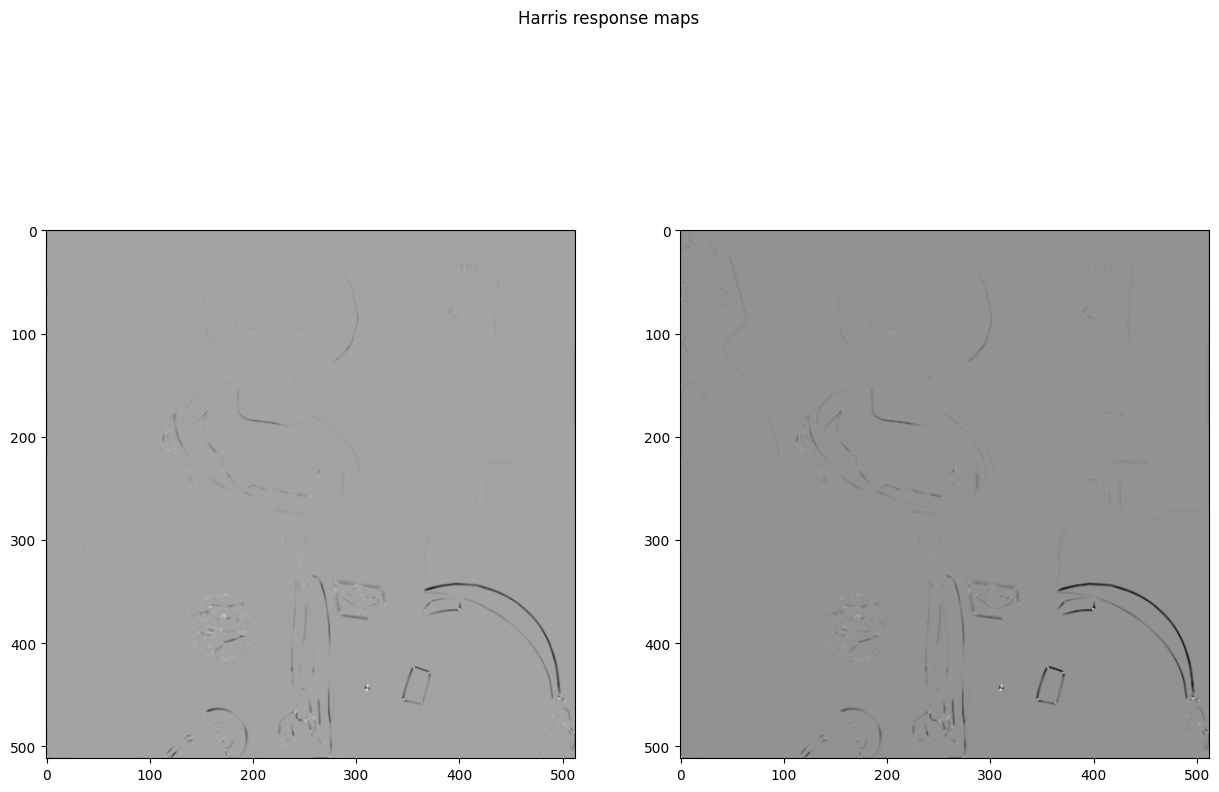

Blurred image is obtained:  71%|███████▏  | 5/7 [02:28<00:51, 25.97s/it]         

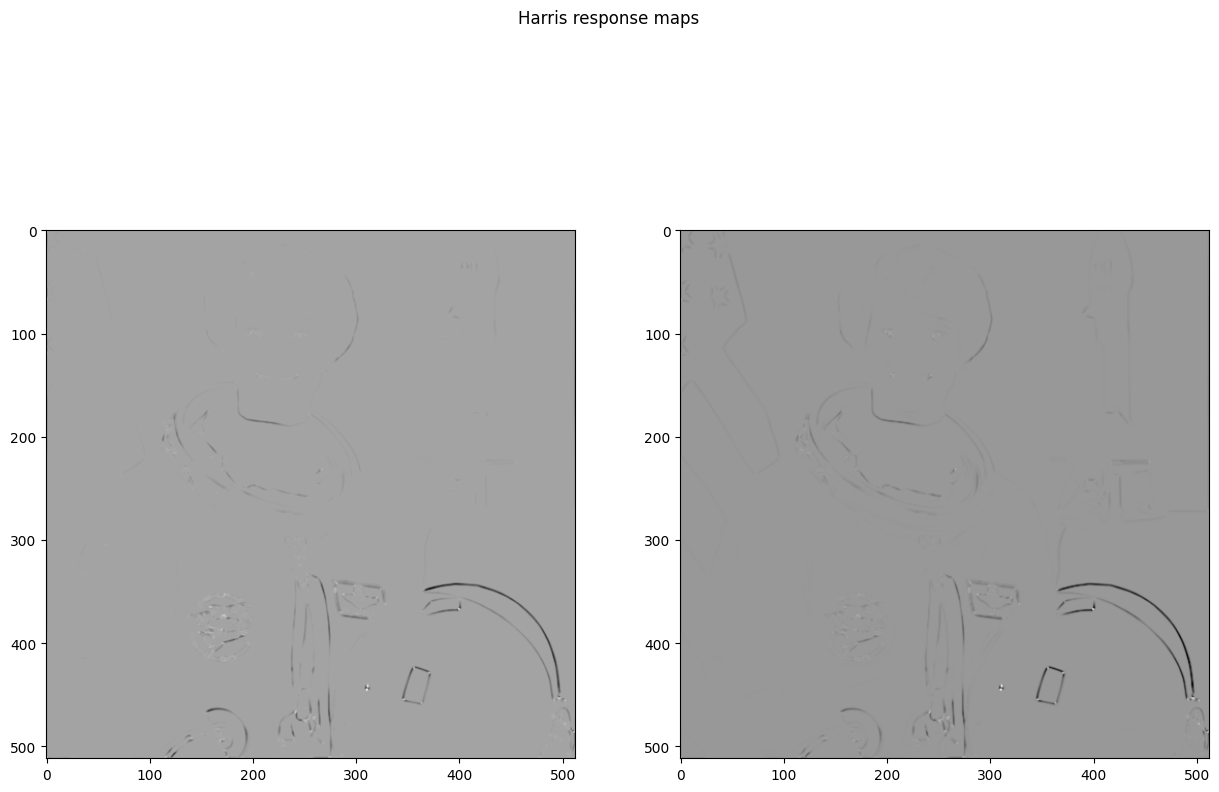

Blurred image is obtained:  86%|████████▌ | 6/7 [04:15<00:33, 33.86s/it]         

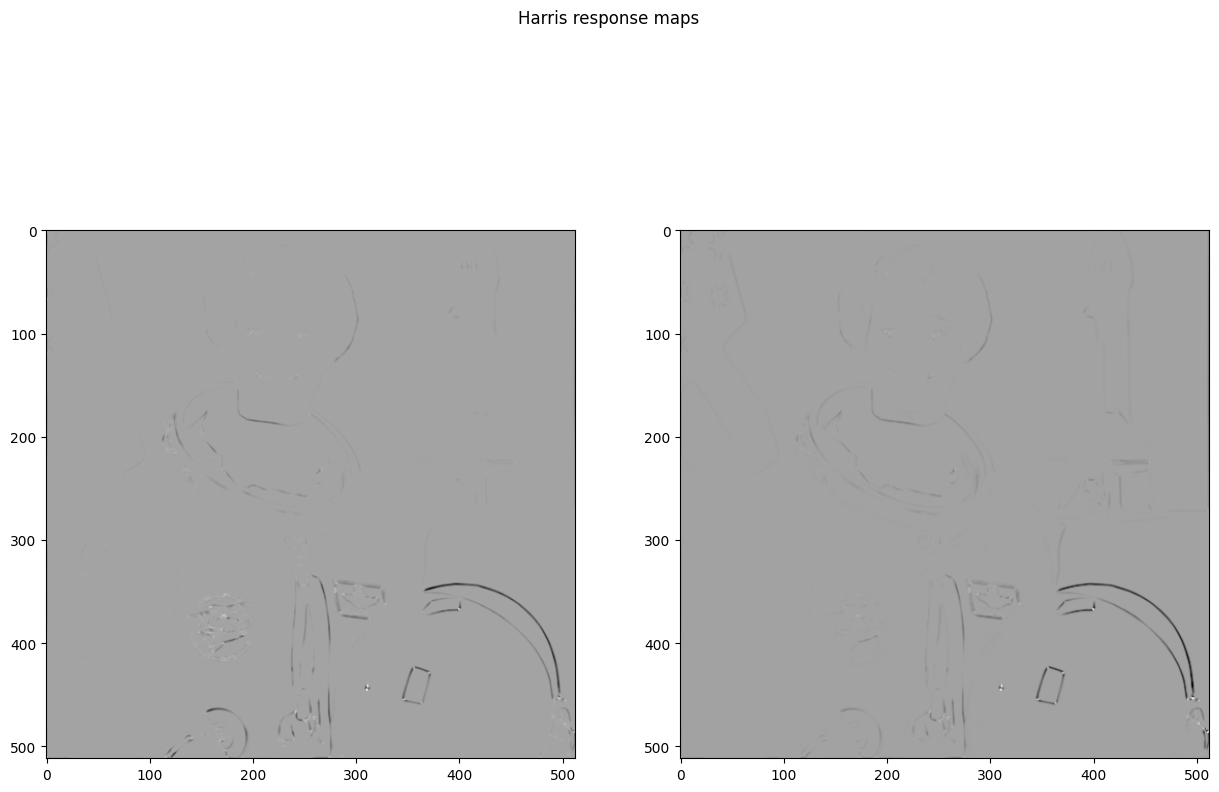

Harris value was obtained as well.: 100%|██████████| 7/7 [04:34<00:00, 39.23s/it]


In [91]:
from tqdm import tqdm
blur_levels = [150, 100, 75, 50, 30, 5, 1]
harris_values = []
blurred_images = []
tvs = []

blur_levels.reverse()
with tqdm(blur_levels, total=len(blur_levels)) as pbar:
    for blur_level in pbar:
        blurred_image = blur_image(img, sigma_color=blur_level, sigma_space=blur_level)
        pbar.set_description("Blurred image is obtained")
        blurred_images.append(blurred_image)
        value = harris_loss(img, blurred_image)
        pbar.set_description("Harris value was obtained as well.")
        harris_values.append(value)
        tvs.append(calculate_total_variation_difference(img, blurred_image))

In [95]:
from typing import Iterable
def min_max_scale(array: Iterable, reverse: bool=True):
    array = np.array(array)
    scaled = (array - min(array)) / (max(array) - min(array))
    if reverse:
        return 1 - scaled
    
    return scaled

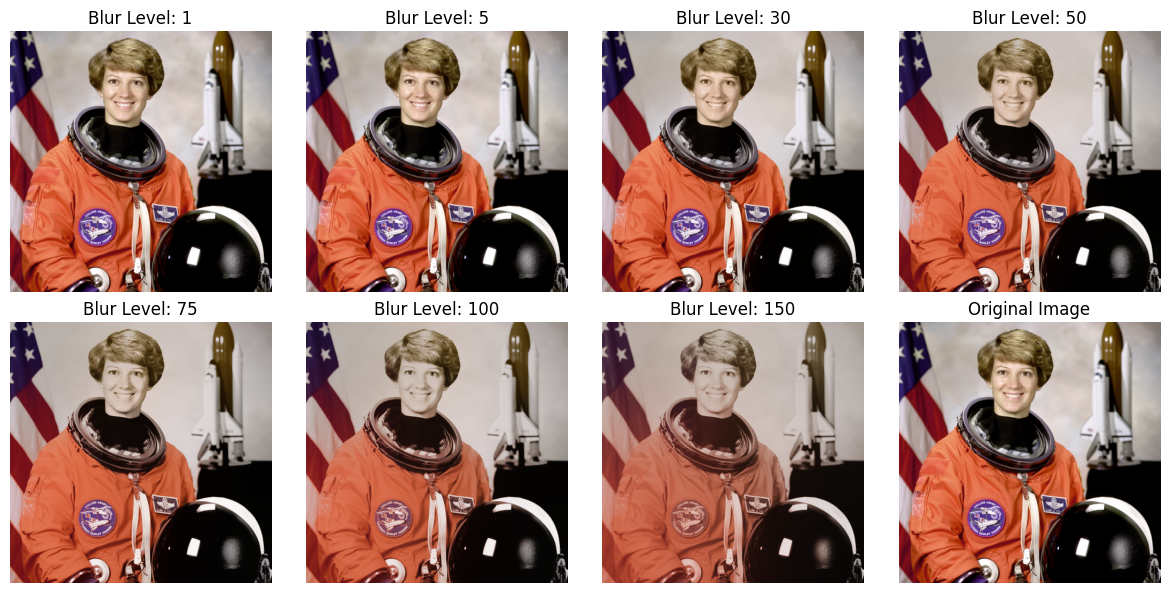

In [96]:
num_images = len(blurred_images)
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# Iterate over the noisy images and plot them in the subplots
for i in range(num_images):
    # Determine the subplot position based on the row and column
    row = i // 4
    col = i % 4
    
    # Plot the noisy image in the corresponding subplot
    axes[row, col].imshow(blurred_images[i], cmap='gray')
    axes[row, col].set_title(f"Blur Level: {blur_levels[i]}")
    axes[row, col].axis('off')


axes[-1, -1].imshow(img, cmap="gray")
axes[-1, -1].set_title("Original Image")
axes[-1, -1].axis('off')
# Adjust the spacing between subplots and display the figure
plt.tight_layout()
plt.show()

In [97]:
# harris_values = [value.sum() for value in harris_values]

In [98]:
harris_values[0]

1.3570800107884693e-06

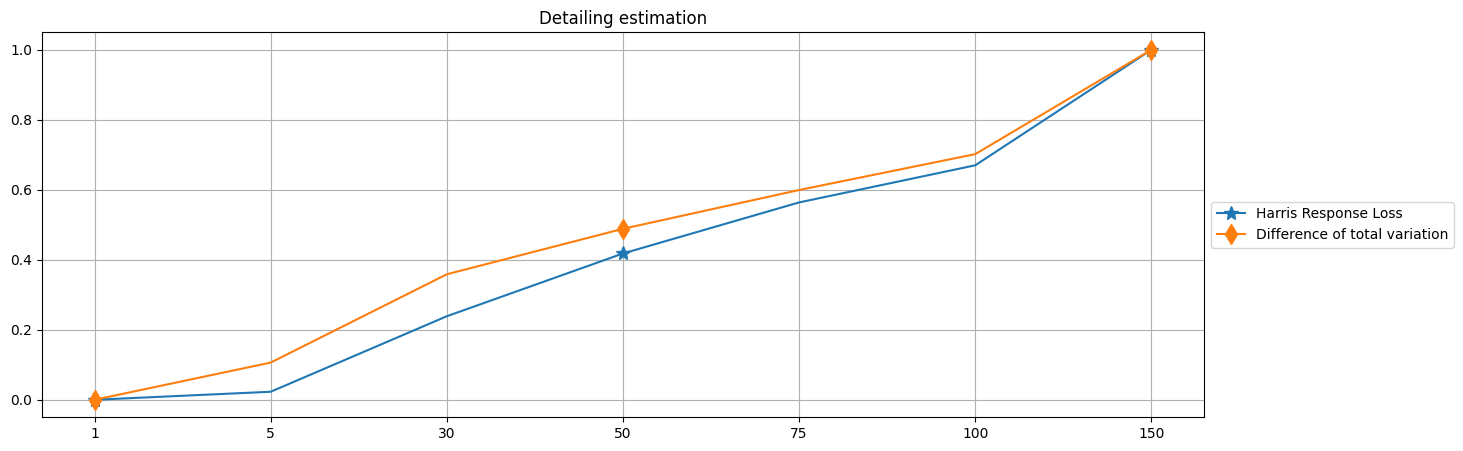

In [99]:
plt.figure(figsize=(15,5))

plt.plot(min_max_scale(harris_values, reverse=False), label='Harris Response Loss', marker='*', markevery=len(harris_values)//2, markersize=10)
plt.plot(min_max_scale(tvs, reverse=False), label="Difference of total variation", marker="d", markevery=len(tvs)//2, markersize=10)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(np.arange(len(blur_levels)), blur_levels)
plt.grid(True)
plt.title("Detailing estimation")
plt.show()

Blurred image is obtained:   0%|          | 0/7 [00:00<?, ?it/s]

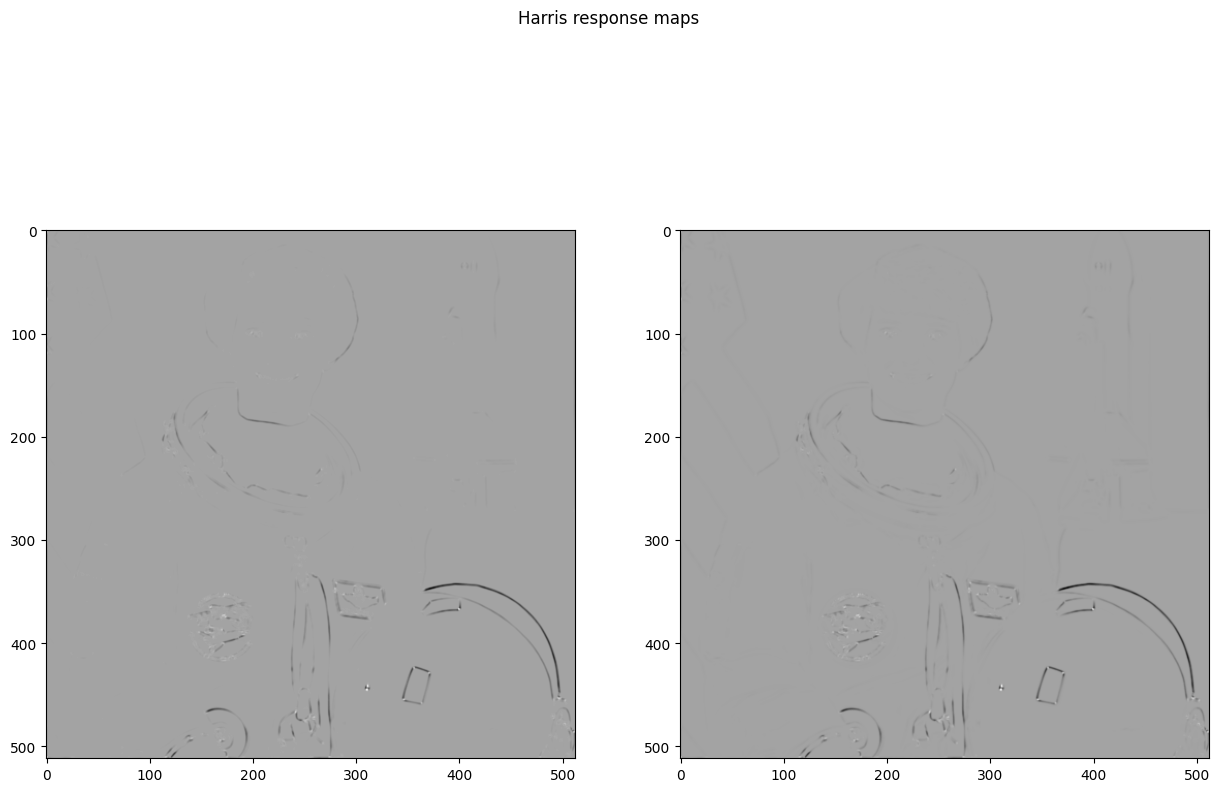

Blurred image is obtained:  14%|█▍        | 1/7 [00:15<01:34, 15.68s/it]         

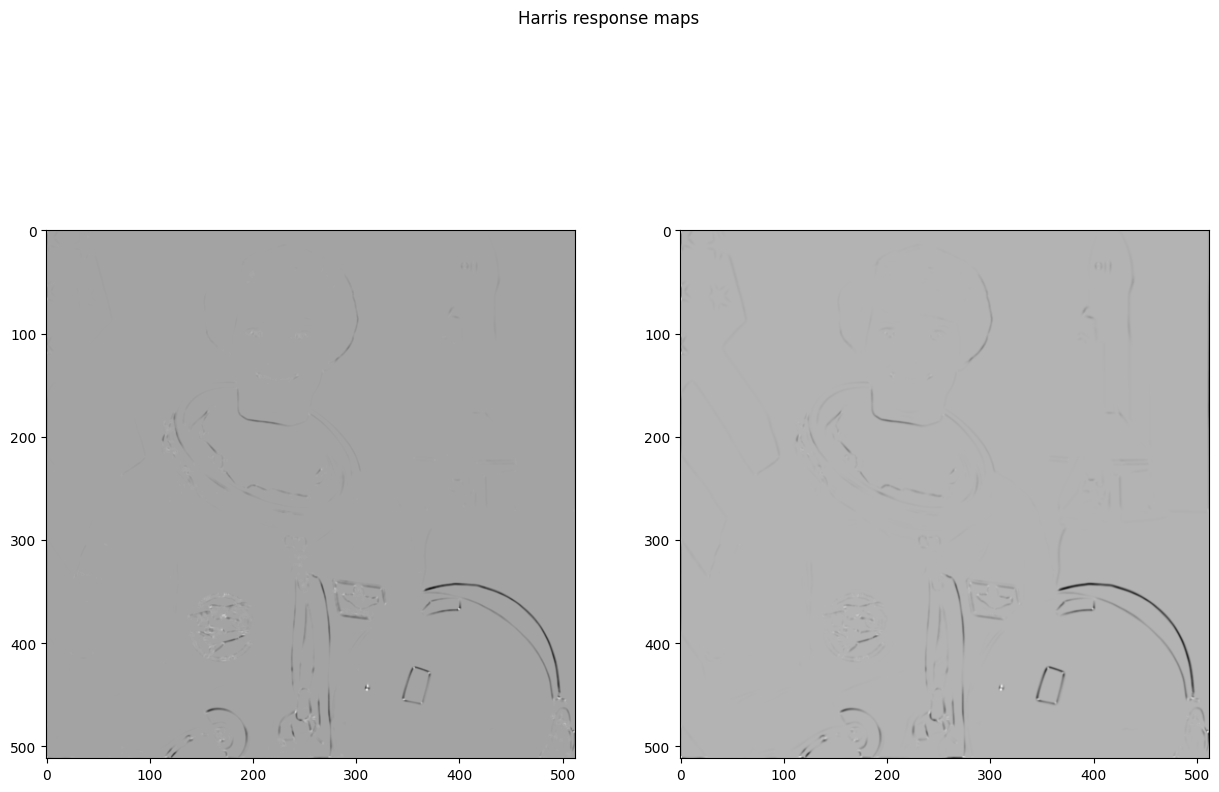

Blurred image is obtained:  29%|██▊       | 2/7 [00:29<01:11, 14.29s/it]         

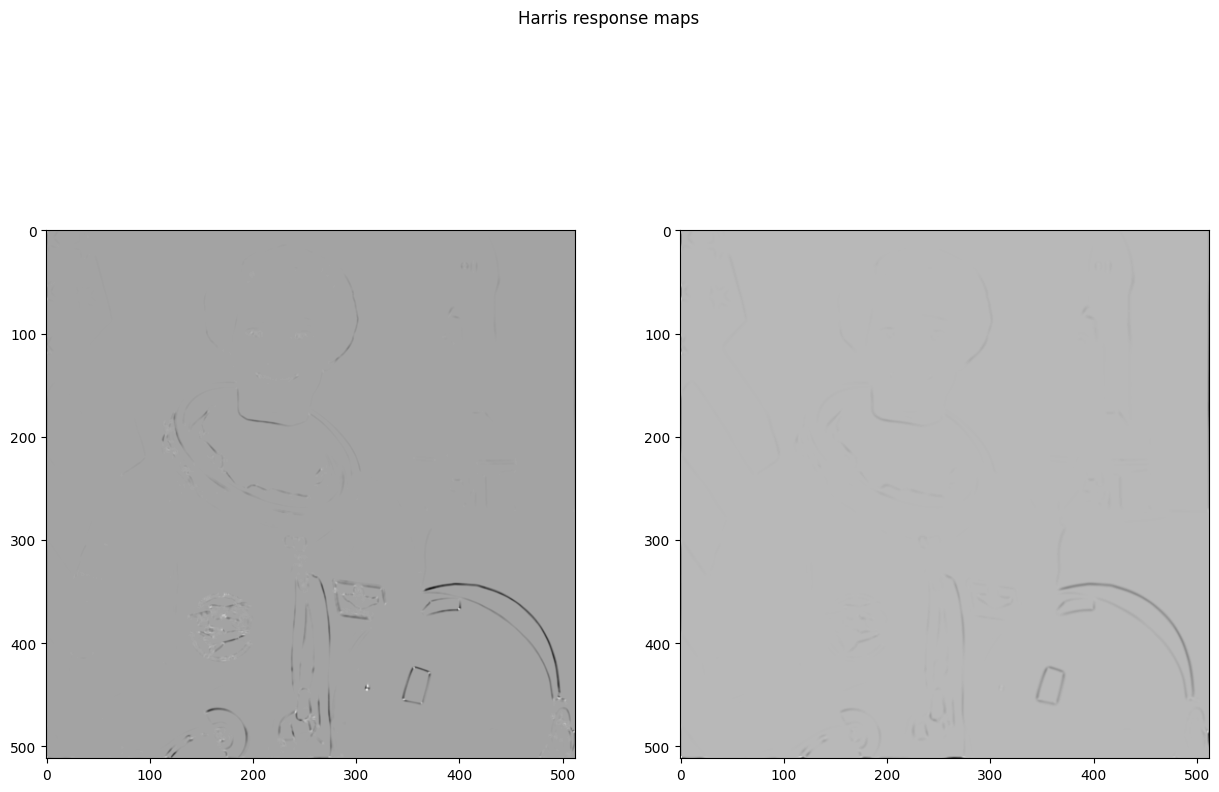

Blurred image is obtained:  43%|████▎     | 3/7 [00:42<00:55, 13.95s/it]         

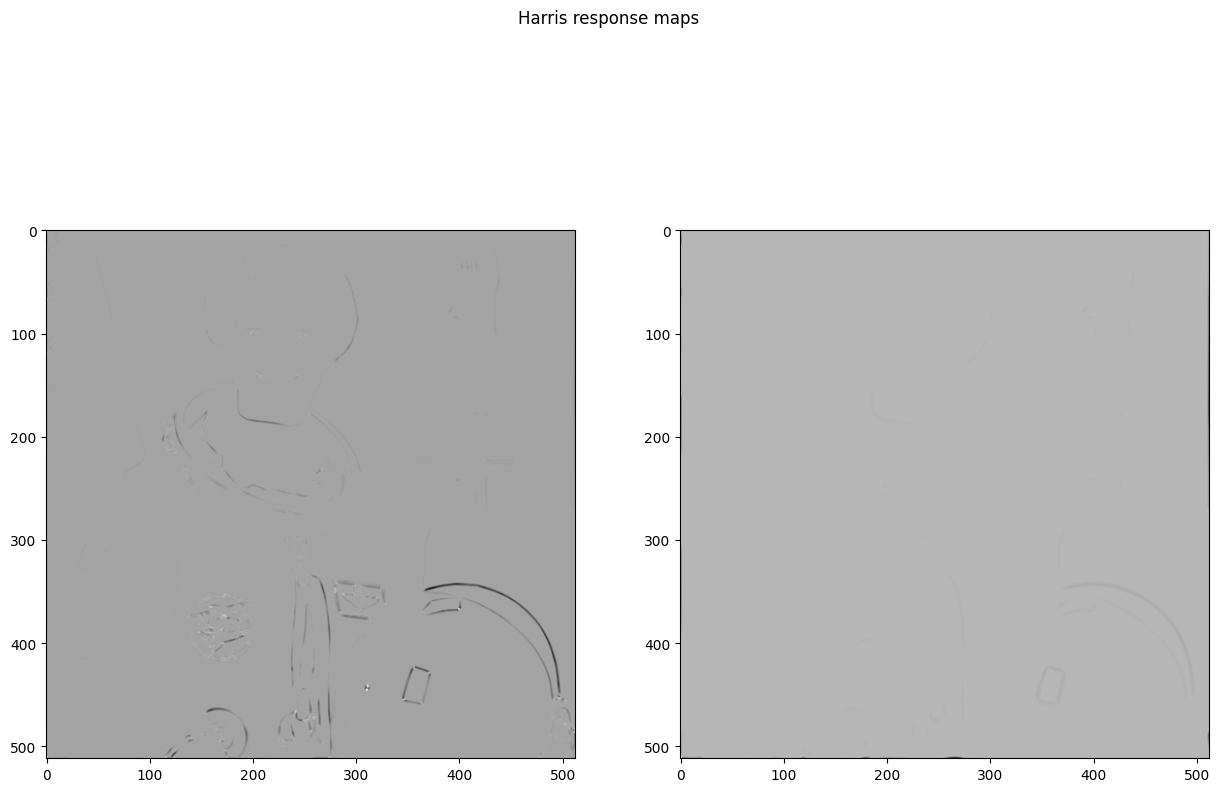

Blurred image is obtained:  57%|█████▋    | 4/7 [00:56<00:41, 13.90s/it]         

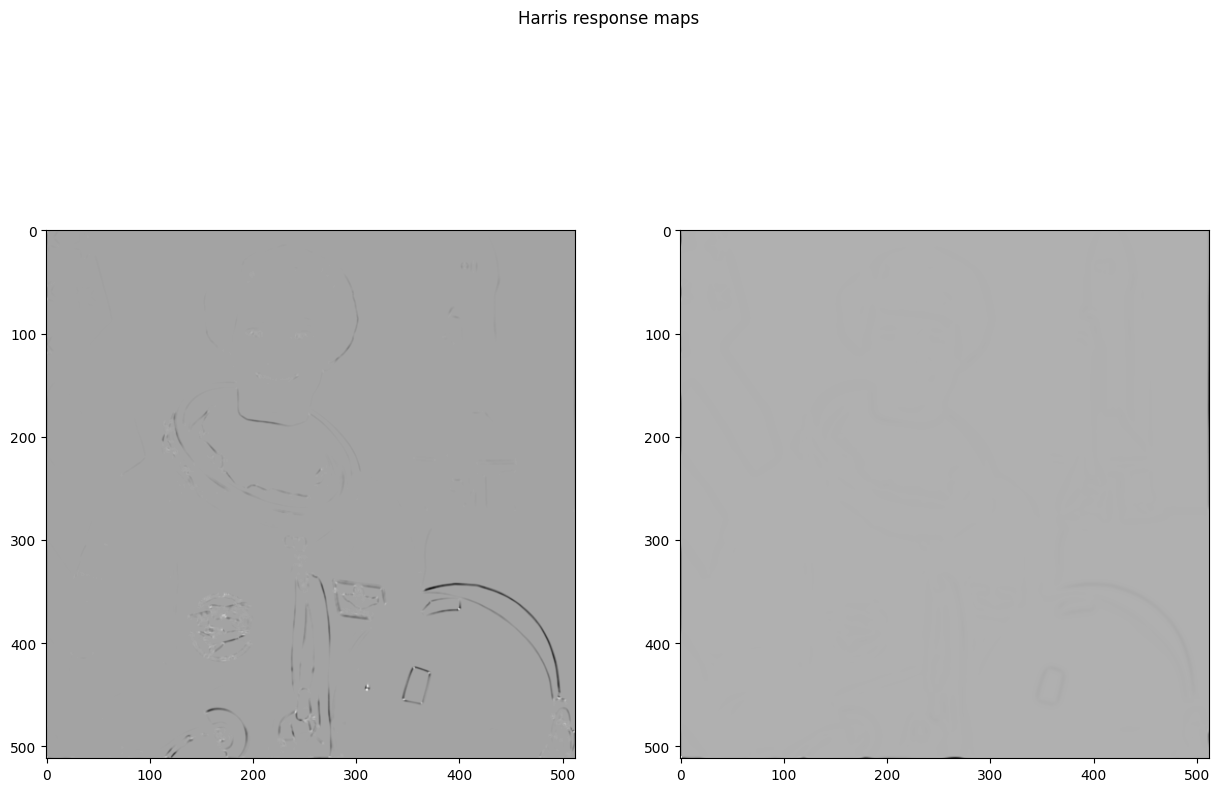

Blurred image is obtained:  71%|███████▏  | 5/7 [01:10<00:27, 13.74s/it]         

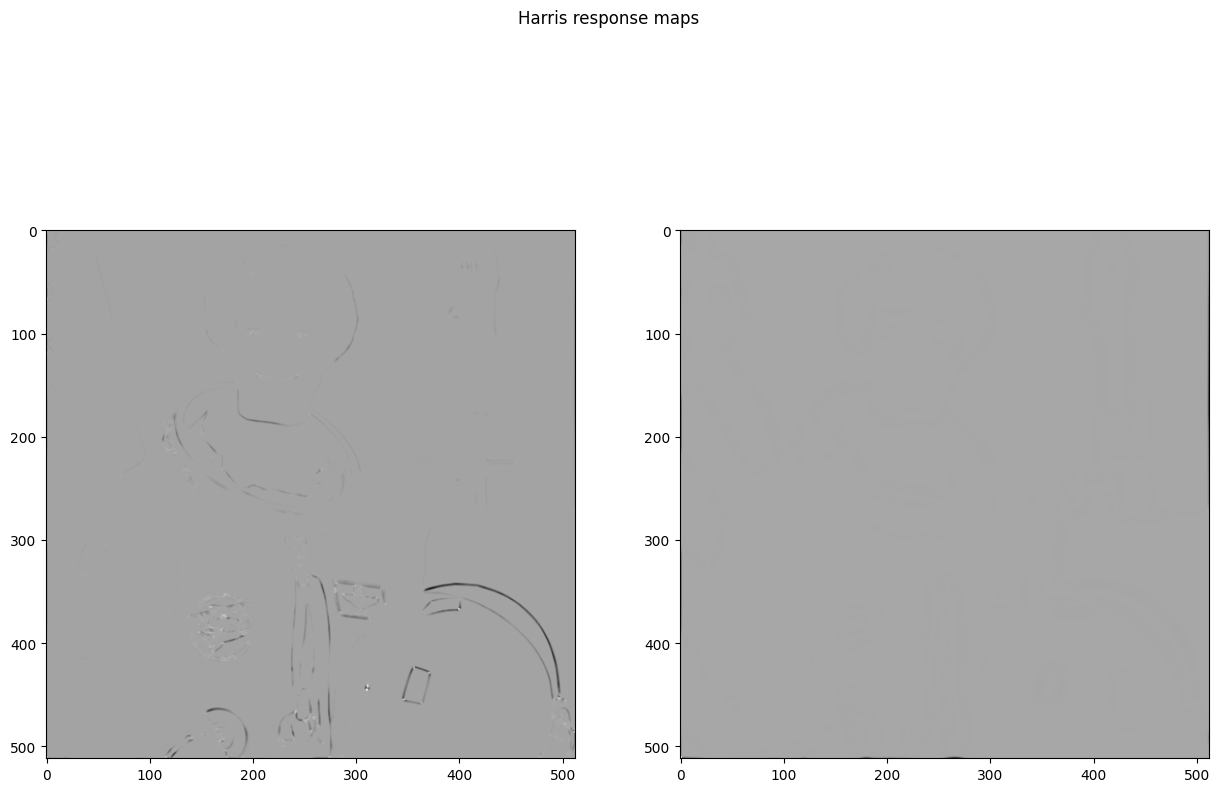

Blurred image is obtained:  86%|████████▌ | 6/7 [01:23<00:13, 13.57s/it]         

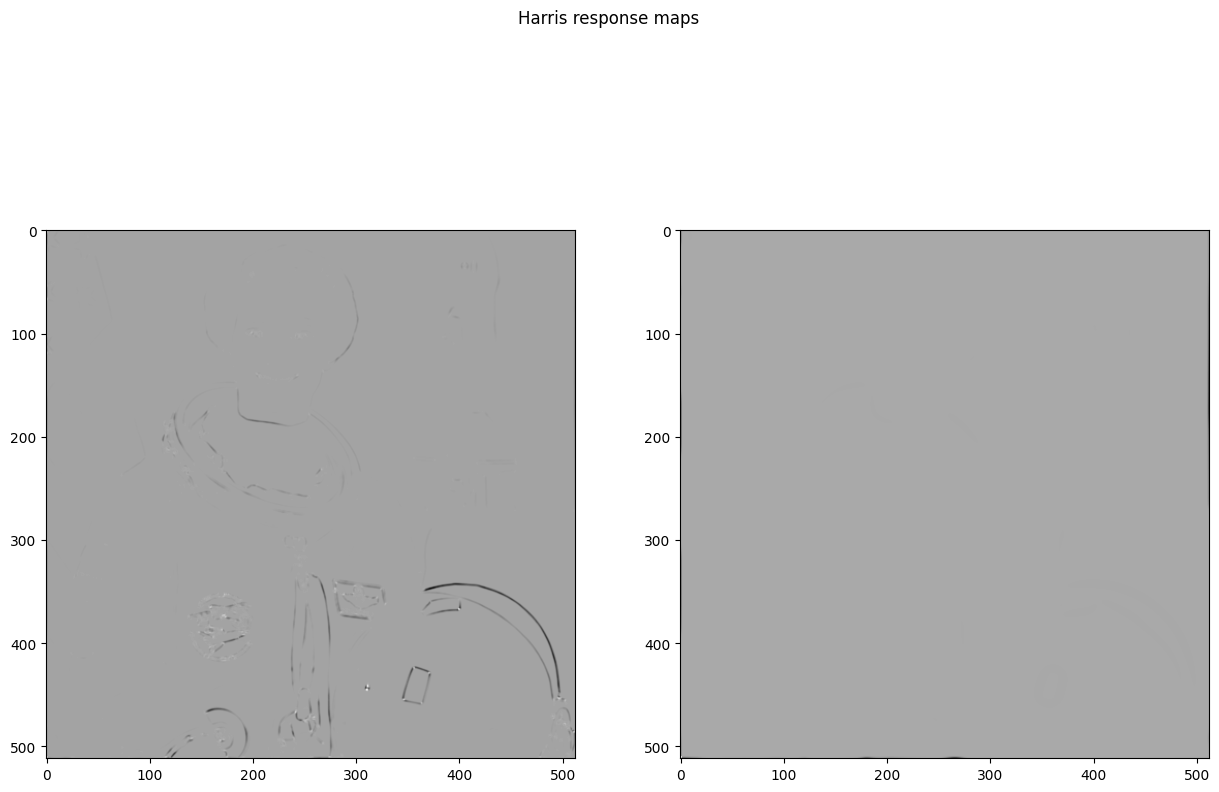

Harris value was obtained as well.: 100%|██████████| 7/7 [01:35<00:00, 13.71s/it]


In [100]:
radius_levels = [31, 25, 17, 13, 7, 3, 1]

blurred_images = []
harris_values = []
radius_levels.reverse()
with tqdm(radius_levels, total=len(radius_levels)) as pbar:
    for radius_level in pbar:
        blurred_image = blur_image(img, radius=radius_level)
        pbar.set_description("Blurred image is obtained")
        blurred_images.append(blurred_image)
        value = harris_loss(img, blurred_image)
        pbar.set_description("Harris value was obtained as well.")
        harris_values.append(value)

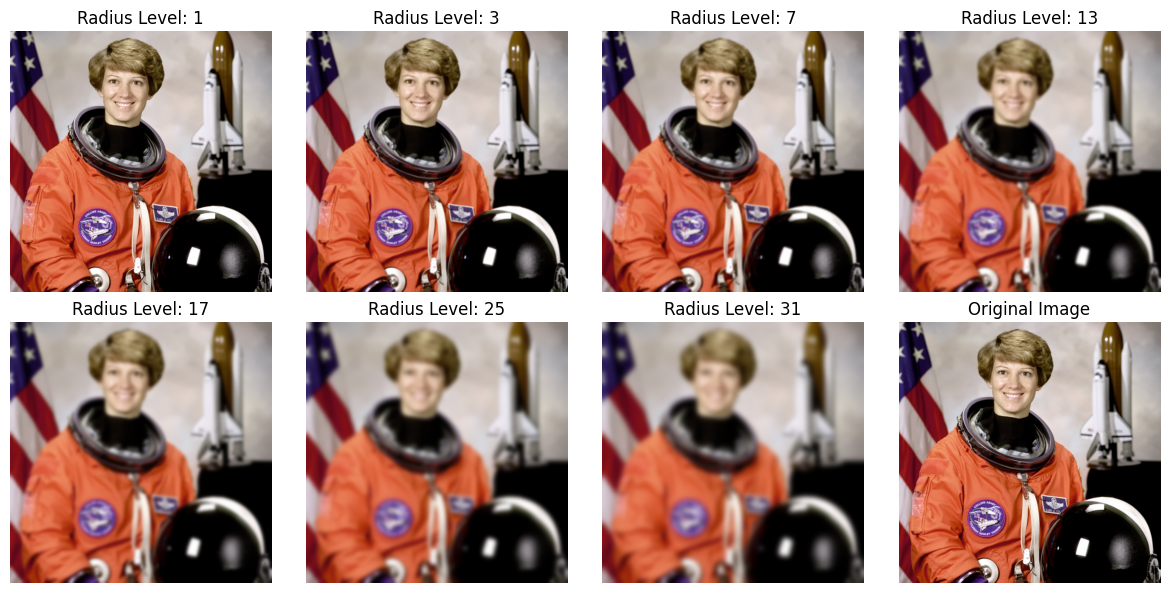

In [101]:
num_images = len(blurred_images)
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# Iterate over the noisy images and plot them in the subplots
for i in range(num_images):
    # Determine the subplot position based on the row and column
    row = i // 4
    col = i % 4
    
    # Plot the noisy image in the corresponding subplot
    axes[row, col].imshow(blurred_images[i], cmap='gray')
    axes[row, col].set_title(f"Radius Level: {radius_levels[i]}")
    axes[row, col].axis('off')


axes[-1, -1].imshow(img, cmap="gray")
axes[-1, -1].set_title("Original Image")
axes[-1, -1].axis('off')
# Adjust the spacing between subplots and display the figure
plt.tight_layout()
plt.show()

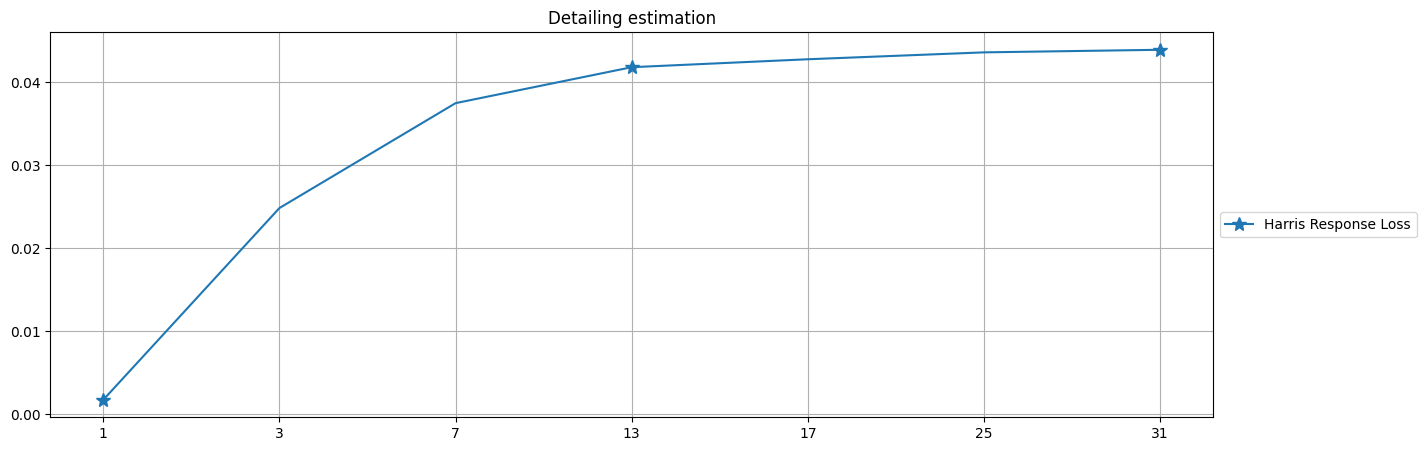

In [102]:
plt.figure(figsize=(15,5))

plt.plot(harris_values, label='Harris Response Loss', marker='*', markevery=len(harris_values)//2, markersize=10)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(np.arange(len(radius_levels)), radius_levels)
plt.grid(True)
plt.title("Detailing estimation")
plt.show()

Вроде, должно быть устойчиво к текстурам.

In [176]:
from numpy.linalg import svd

In [38]:
u, sigma, vt = svd(dy_gauss, full_matrices)

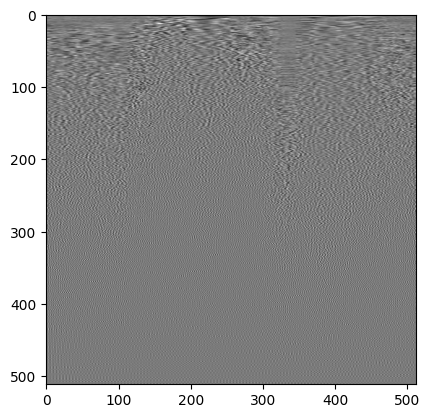

In [43]:
plt.imshow(vt, cmap='gray')

In [66]:
dy_gauss.max()

2.9210256372549024